In [2]:
!pip install rdkit
!pip install torch
!pip install allennlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 KB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 KB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/MolGen/MolGen')

In [ ]:
# %reset_selective MolGenn
# %reset_selective gan_mol



Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])?  n
Nothing done.


In [ ]:
print(type(MolGen))

NameError: ignored

In [ ]:
print(type(gan_mol))

In [5]:
import torch
import numpy as np
import pandas as pd
import pickle as pi
from rdkit import Chem
from model import MolGen
import matplotlib.pyplot as plt

In [6]:
# load data
# data = []
# with open('qm9.csv', "r") as f:
#     for line in f.readlines()[1:]:
#         data.append(line.split(",")[1])

# data = pd.read_csv("database_final_all_100smb_kekule.csv")
data = pd.read_csv("qm9.csv")
x = data["smiles"]

clf = pi.load(open("clf.pkl", "rb"))

# create model
gan_mol = MolGen(x, classifier=clf, hidden_dim=256, disr_lr=0.001, gen_lr = 0.0001, device="cuda")

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
gan_mol

### Pre-train Discriminator on qm9

In [ ]:
# # create dataloader
# loader = gan_mol.create_dataloader(x, batch_size=64, shuffle=True, num_workers=4)

# # initial training for discriminator
# initial_history = gan_mol.initial_train_n_steps(loader, max_step=2000, evaluate_every=50)

In [ ]:
# # stop GAN training
# gan_mol.eval()
# print('ok')

# # save the model weights
# torch.save(gan_mol.state_dict(), "qm9_initial_discr_mol_gan_new.pt")

ok


### Plot GAN Discriminator inital training loss

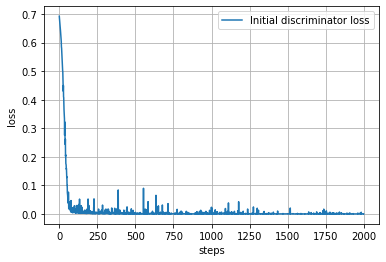

In [ ]:
steps = np.arange(len(initial_history["loss_disc"]))
plt.figure(facecolor = "white")
plt.plot(steps, initial_history["loss_disc"], label="Initial discriminator loss")
plt.legend(loc="upper right")
plt.xlabel("steps")
plt.ylabel("loss")
plt.grid(True)
plt.show()

### Pre-train GAN on all SMILES dataset

In [ ]:
# train model for 10000 steps

# set GAN to the training mode
# gan_mol.train()

# ds = pd.read_csv("concatenated_smiles.csv")
# x = ds["smiles"]

# load initially trained discriminator weights
# gan_mol = MolGen(x, clf, hidden_dim=256, lr=1e-4, device="cuda")
# gan_mol.load_state_dict(torch.load("qm9_initial_discr_mol_gan_new.pt"))

# create dataloader
loader = gan_mol.create_dataloader(x, batch_size=128, shuffle=True, num_workers=5)

pretrain_history = gan_mol.train_n_steps(loader, mode="pretrain", max_step=6000, evaluate_every=50)

In [8]:
# stop GAN training
gan_mol.eval()
print('ok')

# stop model training and save the model weights
# torch.save(gan_mol.state_dict(), "non_bidirect_pretrain_mol_gan.pt")

ok


### Generate Smiles molecules

In [9]:
from rdkit.Chem import PandasTools
from tensorboard.notebook import display
from rdkit.Chem import Draw
# After training
smiles_list = gan_mol.generate_n(10)

valid_smiles = []
for mol in smiles_list:
  if Chem.MolFromSmiles(mol) is not None:
    valid_smiles.append(Chem.MolFromSmiles(mol))
# df = pd.DataFrame(valid_smiles, columns=["smiles"])
valid_smiles

[]

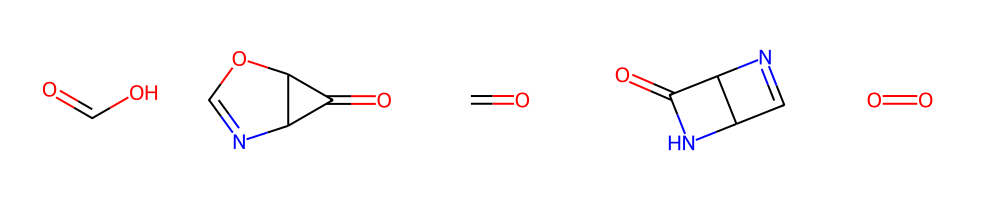

In [9]:
Draw.MolsToGridImage(valid_smiles, molsPerRow=5)

### Plot GAN pre-training loss

In [10]:
pretrain_history.keys()

dict_keys(['loss_disc', 'loss_gen', 'overall_valid'])

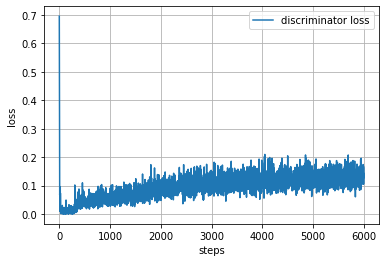

In [17]:
steps = np.arange(len(pretrain_history["loss_disc"]))
plt.figure(facecolor = "white")
plt.plot(steps, pretrain_history["loss_disc"], label="discriminator loss")
# plt.plot(steps, pretrain_history["loss_gen"], label="generator loss")
plt.legend(loc="upper right")
plt.xlabel("steps")
plt.ylabel("loss")
# plt.ylim([-2, 5])
plt.grid(True)
plt.show()

### Train GAN on coformers

In [ ]:
import warnings
warnings.filterwarnings("ignore")

coformer_data = pd.read_csv("database_cof_100smb_kekule.csv")
coformer_x = coformer_data["smiles"]

clf = pi.load(open("clf.pkl", "rb"))

gan_mol = MolGen(coformer_x, classifier=clf, hidden_dim=64, lr=1e-3, device="cpu")
gan_mol.load_state_dict(torch.load("pretrained_mol_gan.pt"))

# set GAN to the training mode
gan_mol.train()

coformer_loader = gan_mol.create_dataloader(coformer_x, batch_size=128, shuffle=True, num_workers=4)

coformer_history = gan_mol.train_n_steps_coformer(coformer_loader, max_step=5000, evaluate_every=50)

FileNotFoundError: ignored

In [ ]:
# save coformer trained GAN
torch.save(gan_mol.state_dict(), "coformer_trained_gan_mol.pt")

### Generate Smiles molecules

In [ ]:
# After training
smiles_list = gan_mol.generate_n(8)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)

### Plot GAN coformer training loss

In [ ]:
steps = len(coformer_history["loss_discr"])
plt.plot(steps, coformer_history["loss_discr"], label="discriminator loss")
plt.plot(steps, coformer_history["loss_gen"], label="generator loss")
plt.legend(loc="upper right")
plt.xlabel("steps")
plt.ylabel("loss")
plt.grid(True)
plt.show()